In [2]:
import pandas as pd
import category_encoders as ce
import matplotlib.font_manager as fm
#from matplotlib.collections import QuadMesh
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import sklearn.metrics as metrics
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import os
import time


In [3]:
#np.random.seed(7)
#iteration=0

In [4]:
df_1 = pd.read_pickle("2018_data_company_type_nb_employes_zip_code_ali.pkl")
df_2 = pd.read_pickle("2019_data_company_type_nb_employes_zip_code.pkl")
df = pd.concat([df_1, df_2], axis=0, sort=False)

In [5]:
df = df.reset_index().drop("index", axis=1)

In [6]:
df = df.sample(frac = 1)
df = df.reset_index().drop('start_date', axis=1).dropna()
df.Zip_Code = df.Zip_Code.apply(lambda x: x[:2])

#df = df.drop("Zip_Code", axis=1)

In [7]:
df = df.drop("index", axis=1)

In [8]:
indc = ((df._get_numeric_data() == df._get_numeric_data().astype(int)) == True).index

In [9]:
df = df.loc[indc]

In [10]:
q = df.Equity.quantile(0.99)
outliers = df[df.Equity > q]

df = df[df.Equity < q]
df = df[df.Target > 0]
df['diff'] = df.Target - df.Equity
q = df['diff'].quantile(0.99)
df = df[df['diff'] < q]
df = df.drop('diff', axis=1)
df = df.dropna()

In [11]:
# keep 2 first numbers of zip code
df = df.drop("entity", axis=1)
df.Target = ((df.Target - df.Equity)>0).astype(int)
#df.Target = (df.Target > 0).astype(int)

In [12]:
numeric_features = df.select_dtypes(include=['int64', 'float64']).drop(['Target'], axis=1).columns
categorical_features = df.select_dtypes(include=['object']).columns
X = df.drop('Target', axis=1)
y = df['Target']
print("Numerical Features: ", list(numeric_features))
print("Categorical Features: ", list(categorical_features))

Numerical Features:  ['AverageNumberOfEmployees', 'ContributedCapital', 'CurrentAssets', 'Equity', 'LiabilitiesAndEquity', 'ProfitLoss', 'ProfitLossFromOrdinaryActivitiesBeforeTax', 'RetainedEarnings', 'ShorttermLiabilitiesOtherThanProvisions']
Categorical Features:  ['Class', 'Zip_Code']


In [13]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)


In [14]:
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=.5)

In [15]:
numeric_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('enc', ce.cat_boost.CatBoostEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])



In [16]:
x_scaler = preprocessor
#y_scaler = StandardScaler()
#scale train
X_train_scaled = x_scaler.fit_transform(X_train, y_train)
#y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1,1))


#scale test
X_test_scaled = x_scaler.transform(X_test)
#y_test_scaled = y_scaler.transform(y_test.values.reshape(-1,1))

#scale validation
X_val_scaled = x_scaler.transform(X_val)
#y_val_scaled = y_scaler.transform(y_val.values.reshape(-1,1))

## Neural Network

In [ ]:
import torch 
#torch.manual_seed(42)
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset
from torch.utils.tensorboard import SummaryWriter


In [1]:
class Dataset(Dataset):
    
    def __init__(self, X, y):
        
        #self.data = dataframe
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)
        
    def __len__(self):
        return len(self.X)
    
    def nb_features(self):
        return self.X.shape[1]
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        sample = self.X[idx] ,self.y[idx]
        
        return sample

NameError: name 'Dataset' is not defined

In [ ]:
batch_size = 64

train_dataset = Dataset(X_train_scaled, y_train.values.reshape(-1,1))
validation_dataset = Dataset(X_val_scaled, y_val.values.reshape(-1,1))
test_dataset = Dataset(X_test_scaled, y_test.values.reshape(-1,1))

# Creating PT data samplers and loaders:
#train_sampler = SubsetRandomSampler(train_indices)
#valid_sampler = SubsetRandomSampler(val_indices)
#test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)


In [ ]:
class NN(nn.Module):
    def __init__(self, input_dim):
        
        super(NN, self).__init__()
        
        self.l1 = nn.Linear(input_dim, 512)
        #self.bn1 = nn.BatchNorm1d(512)
        
        self.l2 = nn.Linear(512, 256)
        #self.bn2 = nn.BatchNorm1d(256)
        
        self.l3 = nn.Linear(256, 128)
        #self.bn3 = nn.BatchNorm1d(64)

        self.l4 = nn.Linear(128, 32)

        
        self.out = nn.Linear(32, 1)


    def forward(self, x):
        
        x = F.dropout(F.relu(self.l1(x)),0.2, training = self.training)
        
        x = F.dropout(F.relu(self.l2(x)),0.2, training = self.training)
        
        x = F.dropout(F.relu(self.l3(x)),0.2, training = self.training)
        
        x = F.dropout(F.relu(self.l4(x)),0.2, training = self.training)


        x = torch.sigmoid(self.out(x))
        
        return x

def weight_init(m):
    if isinstance(m, nn.Linear):
        (nn.init.kaiming_normal_(m.weight))

In [ ]:
def train():
    # set the train mode
    model.train()

    # loss of the epoch
    train_loss = 0
  
    for x, target in train_loader:

        target = target.float().to(device)
        x = x.to(device)
        # update the gradients to zero
        optimizer.zero_grad()

        # forward pass
        ouput = model(x.float())
            
        loss = criterion(ouput, target)

        # backward pass
        loss.backward()
        train_loss += loss.item()

        # update the weights
        optimizer.step()

    return train_loss

In [ ]:
def validate():
    # set the evaluation mode
    model.eval()

    # test loss for the data
    valid_loss = 0

    # we don't need to track the gradients, since we are not updating the parameters during evaluation / testing
    with torch.no_grad():
        for x, target in val_loader:
            # reshape the data
            x = x.float().to(device)
            target = target.float().to(device)

            # forward pass
            output = model(x.float())

            # loss
            loss = criterion(output, target)
            valid_loss += loss.item()

    return valid_loss

def test():
    # set the evaluation mode
    model.eval()

    # test loss for the data
    test_loss = 0

    # we don't need to track the gradients, since we are not updating the parameters during evaluation / testing
    with torch.no_grad():
        for x, target in test_loader:
            # reshape the data
            x = x.float().to(device)
            target = target.float().to(device)

            # forward pass
            output = model(x.float())

            # loss
            loss = criterion(output, target)
            test_loss += loss.item()

    return test_loss

In [ ]:

input_dim = train_dataset.nb_features()
N_EPOCHS = 100
#layers = [2000, 1700, 800, 600, 500, 1000, 250, 900, 200, 100, 100, 100, 100, 100, 50, 25 , 1]
# layers = [512, 256, 128, 64, 1]
# act_funs = ['relu']*len(layers)
model = NN(input_dim)
model.apply(weight_init)
optimizer = optim.Adam(model.parameters())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion = nn.modules.loss.BCEWithLogitsLoss()

In [ ]:
train_history = []
val_history = []

for e in range(N_EPOCHS):
    train_loss = train()
    val_loss = validate()
    #break
    train_loss /= len(train_dataset)
    val_loss /= len(validation_dataset)
    
    
    # Record training loss from each epoch into the writer
    writer.add_scalar('Train/Loss', train_loss, e)
    writer.flush()
    
        
    # Record loss and accuracy from the test run into the writer
    writer.add_scalar('Test/Loss', val_loss, e)
    writer.flush()

    if e%2 == 0:
        print(f'Epoch {e}, Train Loss: {train_loss:.4e}')
        print(f'Epoch {e}, Validation Loss: {val_loss:.4e}')

        f, axarr = plt.subplots(2, 2, figsize=(20, 15))

        ax1 = axarr[0,0]
        ax2 = axarr[0,1]
        ax3 = axarr[1,0]
        ax4 = axarr[1,1]

        ax1.plot(train_history[:], label = 'Training Error')
        ax1.plot(val_history[:], label = 'Validation Error')
        ax1.set_xlabel('Epoch', fontsize=18)
        ax1.set_ylabel('MSE of scaled inputs and outputs', fontsize = 18)
        ax1.set_title('Convergence of network training', fontsize = 18)
        ax1.legend(fontsize=15)

        model.eval()
        train_targets = validation_dataset[:][1]
        ax2.scatter(model(validation_dataset[:][0].to(device).float()).cpu().detach().numpy()[:1000],
                          train_targets[:1000])
        #ax2.plot(train_targets[:1000], label = 'Training target values', alpha = 0.7)
        ax2.set_xlabel('Prediction', fontsize = 18)
        ax2.set_ylabel('Target', fontsize = 18)
        ax2.set_title('Predictions of training data vs Training targets', fontsize = 18)
        #ax2.legend(fontsize=15)

        count = -1
        layer = 0
        for param in model.parameters():
            count += 1
            layer += 1
            ax3.hist(param.data.to(device).cpu().detach().numpy().flatten() , label = f'Layer {layer}')
        ax3.set_title('Distribution of weights for each layer', fontsize = 14)
        ax3.legend()


        count = -1
        layer = 0
        for param in model.parameters():
            count += 1
            layer += 1
            ax4.hist(param.data.to(device).cpu().detach().numpy().flatten(), label = f'Layer {layer}')
        ax4.set_title('Distribution of bias weights for each layer', fontsize = 14)
        ax4.legend()

        plt.savefig('tmp_img.png')
        plt.close(f)
        display(Image(filename='tmp_img.png'))
        clear_output(wait=True)

        os.remove('tmp_img.png')
 
    train_history.append(train_loss)
    val_history.append(val_loss)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
# Make predictions and get the targets
model.eval()
predictions = model(test_dataset[:][0].float().to(device)).detach().numpy()
targets = test_dataset[:][1].float().to(device).detach().numpy()
preds = np.round(predictions.flatten())
print(classification_report(targets, preds))

In [2]:
plo(targets, preds)

NameError: name 'confusion_matrix' is not defined

In [254]:
# Make predictions and get the targets
model.eval()
predictions = model(test_dataset[:][0].float().to(device)).detach().numpy()

# Transform back into scale
unscaled_predictions = y_scaler.inverse_transform(predictions)
unscaled_target = y_scaler.inverse_transform(test_dataset[:][1].float().to(device))
print("Scaled Results")
regression_results(test_dataset[:][1].float().to(device), predictions)
print()
print("Rescaled Results")
regression_results(y_test, unscaled_predictions)

plt.figure(figsize=(15,8))
sns.scatterplot((unscaled_predictions.flatten()), (y_test))

NotFittedError: This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

Text(0, 0.5, 'Error')

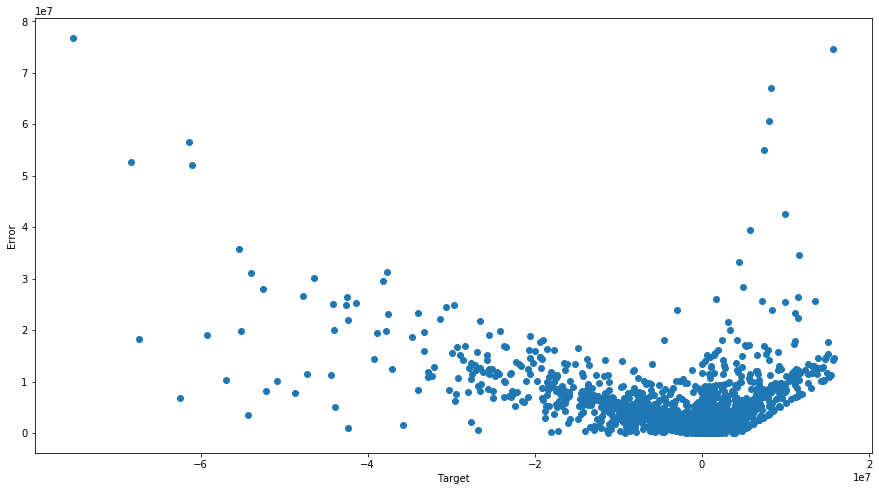

In [162]:
plt.figure(figsize=(15,8))

error = unscaled_predictions - unscaled_target
plt.scatter(unscaled_target, np.abs(error))
plt.xlabel("Target")
plt.ylabel("Error")

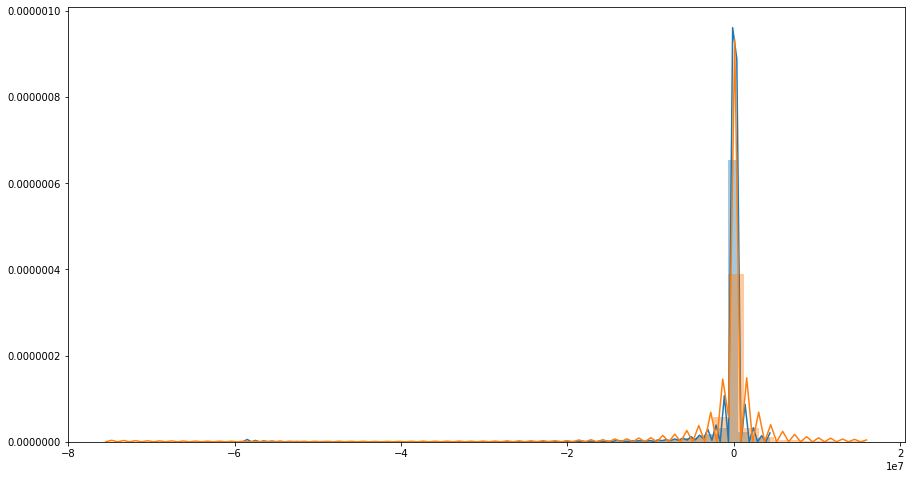

In [164]:
plt.figure(figsize=(15,8))
sns.distplot(unscaled_predictions)
sns.distplot(unscaled_target)

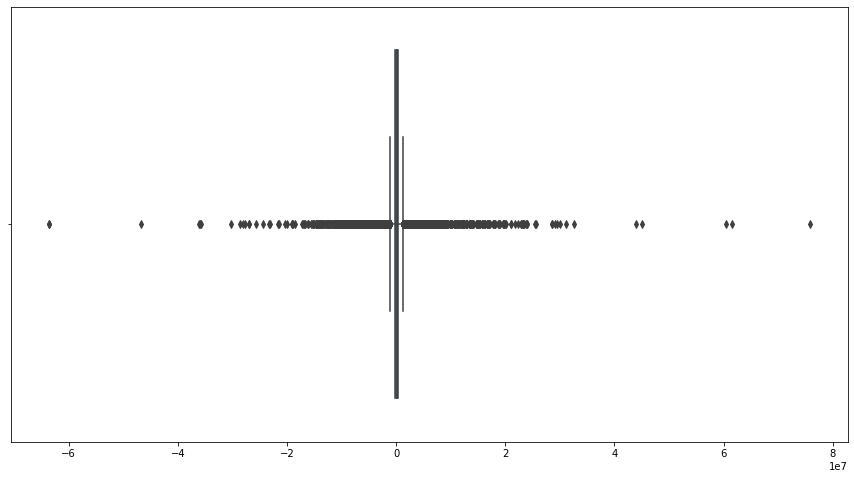

In [149]:
plt.figure(figsize=(15,8))

sns.boxplot(error)

In [145]:
per_point_abs_error[0][0]

55969760.0

/home/evangelos/Projects/DTU_Deep_Learning_Project/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  
/home/evangelos/Projects/DTU_Deep_Learning_Project/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


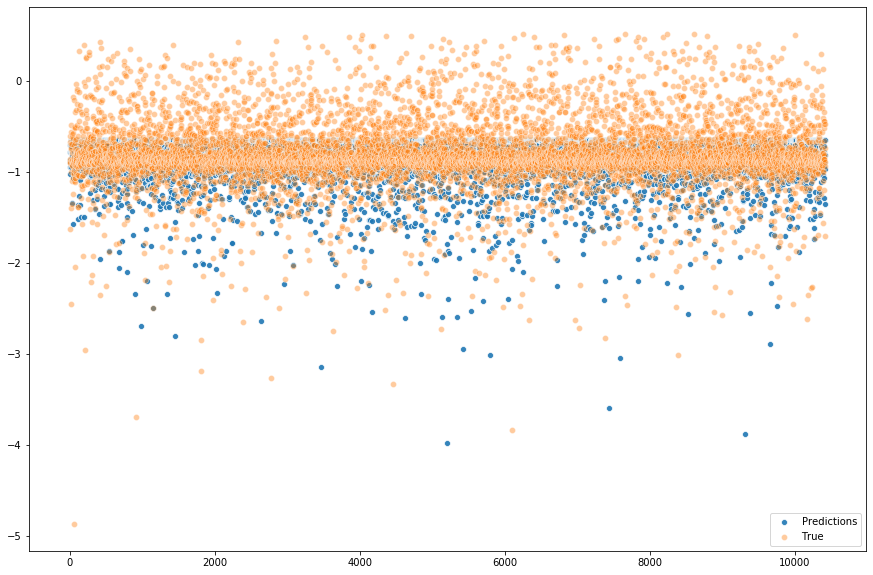

In [146]:
plt.figure(figsize=(15,10))
sns.scatterplot(list(range(len(y_test))), np.log10(predictions.flatten()),alpha=0.9, label='Predictions')
sns.scatterplot(list(range(len(y_test))), np.log10(y_test_scaled.flatten()),alpha=0.4, label='True')
plt.legend()
plt.show()

/home/evangelos/Projects/DTU_Deep_Learning_Project/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  
/home/evangelos/Projects/DTU_Deep_Learning_Project/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


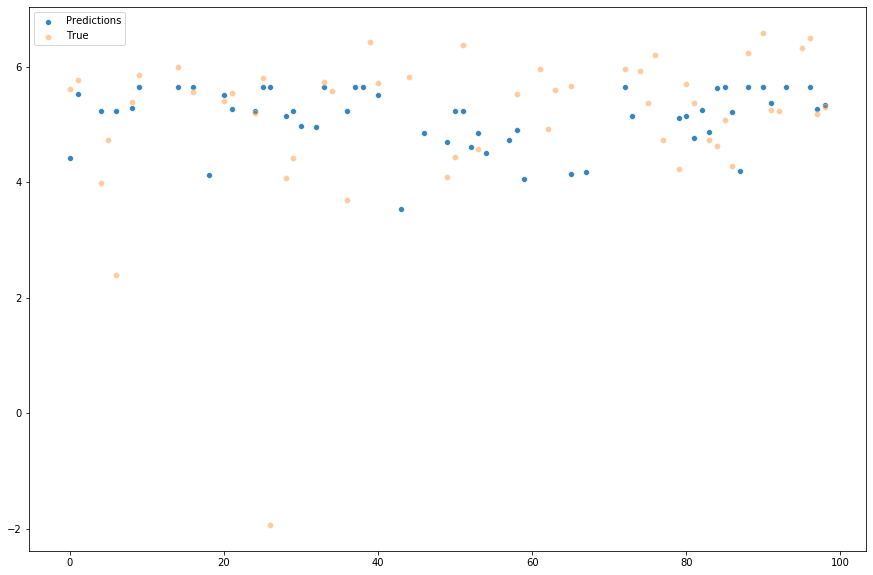

In [147]:
plt.figure(figsize=(15,10))
sns.scatterplot(list(range(len(y_test[:100]))), np.log10(unscaled_predictions.flatten()[:100]),alpha=0.9, label='Predictions')
sns.scatterplot(list(range(len(y_test[:100]))), np.log10(unscaled_target.flatten()[:100]),alpha=0.4, label='True')
plt.legend()
plt.show()

In [ ]:
best_r2 = 0.72
iteration +=1
MAE = metrics.mean_absolute_error(unscaled_target, unscaled_predictions)
MSE = metrics.mean_squared_error(unscaled_target, unscaled_predictions)
print(f'MAE of test set: {MAE}')
print(f'MSE of test set: {MSE}')
print(f'R^2 score: {metrics.r2_score(unscaled_target, unscaled_predictions)}' )
print(f'Explained Variance: {metrics.explained_variance_score(unscaled_target, unscaled_predictions)}')

test_loss = test()
print(f'Test Loss: {test_loss:.4e}')
print(f'Percentage we are off on average based on MAE: {MAE/np.mean(unscaled_target):.4e}')


if metrics.r2_score(unscaled_target, unscaled_predictions)>best_r2:
    print('Model Saved')
    best_r2 = metrics.r2_score(unscaled_target, unscaled_predictions)
    torch.save(model, f'models/model_{iteration}_R2_{round(best_r2, 3)}')
    torch.save(model.state_dict(), f'models/model_{iteration}_R2_{round(best_r2, 3)}_params.pkl')

In [ ]:
from tabulate import tabulate
from datetime import datetime

def latex_architecture(latex,scl_name,scl,opt_name,opt,crit,rm_pol,mod,sc):
  if(latex):
    def print_func(x):print(tabulate(x, tablefmt="latex_raw"))
  else:
    def print_func(x): 
      for el in x: print(el)
      print("")

  #print(print_func(table))
  #if(latex):print(tabulate(table, tablefmt="latex_raw"))
  #else: print(table)
  table = [["scaler attributes", ""],
           ["Scaler",scl_name]]
  pars = list(scl.get_params())
  for par in pars: table.extend([[par,scl.get_params()[par]]])
  print_func(table)
  
  #removal policy
  print_func(rm_pol)#print(tabulate(rm_pol, tablefmt="latex_raw"))
  #optimizer
  table = [["Optimizer attributes:", ""],
           ["Optimizer",opt_name]]
  attr = opt.defaults
  for att in attr: table.extend([[att,opt.defaults[att]]]) 
  print_func(table)
  #print(tabulate(table, tablefmt="latex_raw"))

  #criterion
  table = [["Criterion atttributes:", ""],
           ["Loss function",crit]]
  print_func(table)
  #model architecture
  layers = mod._modules.items()
  table = [["Layers:"]]
  for layer in layers: table.extend([[layer[1]]])
  
  #print(tabulate(table, tablefmt="latex_raw"))
  print_func(table)
  #score
  #print(tabulate(sc, tablefmt="latex_raw"))
  print_func(sc)
  

  return()
removal_policy = [['Data Removal:'],['Keep only newest instance'],['All columns that sum to zero'],
                  ['All attributes with "date"'],
                  ['Attribute AARSRAPPORT_pdf'],
                  ['Attribute AARSRAPPORT_html'],
                  ['Attribute AARSRAPPORT_xml'],
                  ['Attribute _score'],
                  ['Attribute entity'],
                  ['Attribute cvrNummer'],
                  ['Attribute regnskabsperiode_startDato'],
                  ['Attribute sidstOpdateret'],
                  ['Attribute sagsNummer'],
                  ['Attribute regnskabsperiode_slutDato'],
                  ['Attribute _index'],
                  ['Attribute context'],
                  ['Attribute end_date'],
                  ['Attribute offentliggoerelsesTidspunkt'],
                  ['Attribute indlaesningsTidspunkt'],
                  ['Attribute indlaesningsId'],
                  ['Attribute _id'],
                  ['Attribute regNummer']]
score = [['Score:',""],['MAE',MAE],
         ['R2',metrics.r2_score(unscaled_target, unscaled_predictions)],
         ['Explained Variance', metrics.explained_variance_score(unscaled_target, unscaled_predictions)],
         ['MAE adjusted for mean',MAE/np.mean(unscaled_target)]
         ]
latex_architecture(latex=True,scl_name='X_scaler',scl=x_scaler,
                   opt_name="Adam",opt=optimizer,rm_pol=removal_policy,mod=model, crit=criterion,
                   sc=score)
